In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import keras
import matplotlib.pyplot as plt

from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma

2025-10-27 05:51:34.214131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = keras.ops.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = keras.ops.one_hot(y_test, 10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1761540727.939873   12361 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 642 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [3]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf_data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [5]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = keras.ops.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = keras.ops.reshape(l, (batch_size, 1, 1, 1))
    y_l = keras.ops.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.0, 0.0, 0.0, 0.0003417590050958097, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996582269668579]
[0.0, 0.0, 0.0, 0.0, 0.14041084051132202, 0.0, 0.0, 0.859589159488678, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.03455692529678345, 0.0, 0.0, 0.0, 0.9654430747032166]
[0.0, 0.0, 0.0, 0.1722179353237152, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8277820348739624]
[0.17738527059555054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8226147294044495]
[0.0, 0.0, 0.02727867290377617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9727213382720947, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 5.551274995241329e-10, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.782376229763031, 0.0, 0.0, 0.0, 0.0, 0.217623770236969, 0.0]
[0.7149720191955566, 0.0, 0.28502795100212097, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


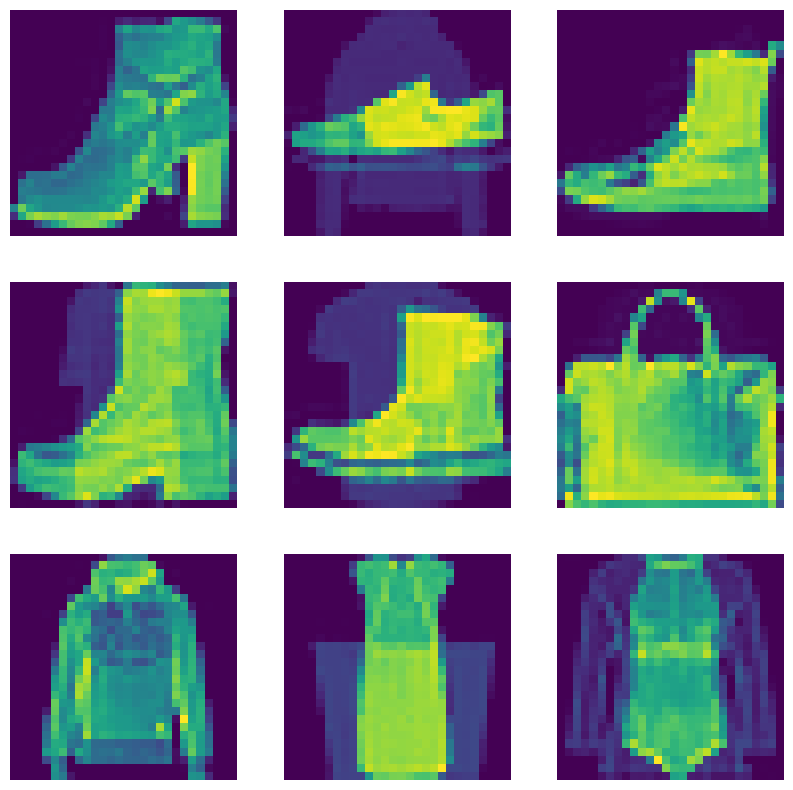

In [6]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO,
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [7]:
def get_training_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

In [8]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.weights.h5")

In [9]:
model = get_training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10


2025-10-27 05:54:57.863231: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b48cc00d850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-27 05:54:57.863246: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-27 05:54:57.884096: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-27 05:54:57.999721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-27 05:54:58.194228: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,12,12]{3,2,1,0}, f32[32,16,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cu

140/907 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2456 - loss: 2.0456

I0000 00:00:1761540899.143691   12479 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


874/907 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4837 - loss: 1.4978

2025-10-27 05:55:00.329289: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,16,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,28,28]{3,2,1,0}, f32[16,1,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-27 05:55:00.339021: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,16,12,12]{3,2,1,0}, f32[32,16,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4879 - loss: 1.4885

2025-10-27 05:55:01.364153: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,12,12]{3,2,1,0}, f32[32,16,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6003 - loss: 1.2388 - val_accuracy: 0.7290 - val_loss: 0.7750
Epoch 2/10


2025-10-27 05:55:01.593476: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,16,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,28,28]{3,2,1,0}, f32[16,1,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-27 05:55:01.600299: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,16,12,12]{3,2,1,0}, f32[32,16,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7131 - loss: 0.9795 - val_accuracy: 0.7870 - val_loss: 0.6015
Epoch 3/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7484 - loss: 0.8941 - val_accuracy: 0.8135 - val_loss: 0.5511
Epoch 4/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7758 - loss: 0.8383 - val_accuracy: 0.8345 - val_loss: 0.5046
Epoch 5/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7877 - loss: 0.8041 - val_accuracy: 0.8445 - val_loss: 0.4676
Epoch 6/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7970 - loss: 0.7810 - val_accuracy: 0.8460 - val_loss: 0.4520
Epoch 7/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8033 - loss: 0.7641 - val_accuracy: 0.8430 - val_loss: 0.4452
Epoch 8/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8078 - loss: 0.7519 - val_accuracy: 0.8635 - val_loss: 0.4165
Epoch 9/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8112 - loss: 0.7328 - val_accuracy: 0.8625 - val_

In [ ]:
model = get_training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6364 - loss: 0.9636 - val_accuracy: 0.7340 - val_loss: 0.7360
Epoch 2/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7379 - loss: 0.6922 - val_accuracy: 0.7685 - val_loss: 0.6216
Epoch 3/10
302/907 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7542 - loss: 0.6299